In [1]:
import numpy as np
import GPy
import seaborn as sns
import math
import matplotlib.pyplot as plt
import edward as ed
import tensorflow as tf
from edward.models import MultivariateNormalFullCovariance, Normal
from scipy.stats import bernoulli
from tqdm import tqdm

## Simulate data using Intensity function

> $$ \lambda_1(s) = 2 \exp\{-s/15\} + \exp\{-((s-25)/10)^2\}$$
> $$ \lambda_2(s) = 5 \sin(s^2) + 6$$

In [66]:
def build_toy_dataset1():
    rate = 2
    measure = 50
    N = 2 * np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 2*np.exp(-S/15) + np.exp(-((S-25)/10)**2)
    print(N)
    return S, Z, N, rate, measure

def build_toy_dataset2():
    rate = 12
    measure = 5
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 5 * np.sin(S**2) + 6
    print(N)
    return S, Z, N, rate, measure


## Generate and plot data

10
222


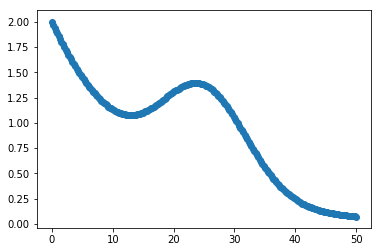

In [69]:
#hyper_params = np.array([10, 1])
print(hyper_params[0])
kern = GPy.kern.RBF(input_dim=1, lengthscale=8, variance=1)
#k = GPy.kern.PeriodicExponential(input_dim=1, period=2, variance=7) - > best fit p=2, var=7
S, Z, N, rate, measure = build_toy_dataset1()
plt.scatter(S, Z)
plt.show()

## Thinning events to keep data points consistent with the intensity function

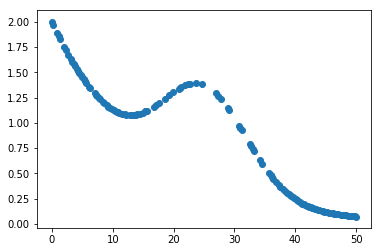

(222, 134)


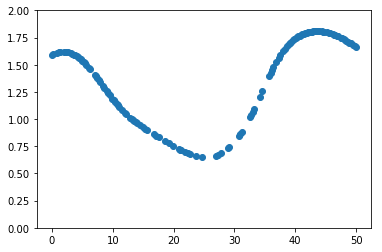

In [70]:
R = np.random.uniform(0, 1, N)
V = (Z / rate).flatten()
G = np.random.multivariate_normal(np.zeros((S.shape[0])), kern.K(S, S))
accept = np.where(R < (1 / (1 + np.exp(-G))))
S_k  = np.take(S, accept, axis=0).reshape(-1,1)
Z_k  = np.take(Z, accept, axis=0).reshape(-1)
#G_k = np.log(Z_k / (rate - Z_k)).reshape(-1)
G_k = np.take(G, accept, axis=0).reshape(-1)#random.multivariate_normal(np.zeros((S_k.shape[0])), k.K(S_k,S_k))
#X = k.K(S_k, S_k)
plt.scatter(S_k, Z_k)
plt.show()
K = S_k.shape[0]
print(N,K)
plt.ylim((0,rate))
plt.scatter(S_k, rate/(1+np.exp(-G_k)))
plt.show()

In [ ]:
#prior_loss = 0.5 * np.matmul(np.expand_dims(G_k, axis=0), np.matmul(np.linalg.inv(X + 1e-6*np.eye(K)), np.expand_dims(G_k, axis=1)))
prior_loss = 0.5 * np.matmul(np.expand_dims(G_k, axis=0), np.expand_dims(G_k, axis=1))
like_loss = np.sum(np.log(np.ones(K) + np.exp(-G_k)))
print(like_loss)
#likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
#likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
loss = prior_loss + like_loss
print(loss)

### Conditional for Gaussian process

In [5]:
def conditional(x_new, x, y, k):

    B = k.K(x_new, x)
    C = k.K(x,x)
    A = k.K(x_new, x_new)
    N = len(C)
    mu = B.dot(np.linalg.inv(C + 1e-6*np.eye(N))).dot(y)
    sigma = A - B.dot(np.linalg.inv(C + 1e-6*np.eye(N)).dot(B.T))
    #print(mu.shape, sigma.shape)
    return(mu.squeeze(), sigma.squeeze())

In [6]:
def slice_sampling(g, S, K, n_iter=5000):
    burn_in = 1000
    cov = kern.K(S, S)
    
    cov_inv = np.linalg.inv(cov + 1e-5 * np.eye(len(S)))
    vec = np.zeros((n_iter, len(S)), dtype=np.float32)
    cand = np.random.multivariate_normal(np.zeros(len(S)), cov, n_iter)
    for i in range(n_iter):
        u = np.random.uniform()
        log_y = log_posterior(g, cov_inv, K) + np.log(u)
        theta = np.random.uniform(low=0.0, high=2*np.pi)
        theta_min, theta_max = theta - 2*np.pi, theta
        while(True):
            new = np.cos(theta)*g + np.sin(theta)*cand[i]
            if log_posterior(new, cov_inv, K) > log_y:
                vec[i] = new.reshape(-1)
                break
            else:
                theta_min, theta_max = (theta, theta_max) if theta<0 else (theta_min, theta)
                theta = np.random.uniform(low = theta_min, high=theta_max)
        
        g = vec[i]
                
    G = np.mean(np.array(vec)[burn_in:], axis=0)
    return G

def slice_sampling_tf(g, S, K, n_iter=5000):
    burn_in = 1000
    

In [7]:
def log_posterior(g, cov_inv, K):
    
    #gX = np.matmul(np.transpose(g), cov_inv)
    #gXg = 0.5 * np.matmul(gX, g)
    log_prior = np.sum(np.log(1 + np.exp(-g[:K]))) + np.sum(np.log(1 + np.exp(g[K:])))
    return -log_prior

def log_post_hyper(g, S, params):
    
    kern = GPy.kern.RBF(input_dim=1, lengthscale=params[0], variance=params[1])
    cov = kern.K(S, S)
    cov_inv = np.linalg.inv(cov + 1e-6*np.linalg.inv(cov))
    sigma = np.eye(len(params))
    #log_prior = - 0.5 * np.matmul(np.transpose(np.log(np.log(1 + np.exp(params)))), np.matmul(np.linalg.inv(sigma), np.log(np.log(1 + np.exp(params)))))
    gX = np.matmul(np.transpose(g), cov_inv)
    gXg = 0.5 * np.matmul(gX, g)
    like_prior = gXg + 0.5 * np.log(np.linalg.norm(cov))
    return -like_prior

In [8]:
def log_post_tf(g, cov_inv, K):
    log_prior = tf.reduce_sum(tf.log(1 + tf.exp(-tf.slice(g,[0,0],[K,1])))) + tf.reduce_sum(tf.log(1 + tf.exp(tf.slice(g, [K,0],[-1,1]))))
    return -log_prior

In [9]:
def slice_hyper(g, S, params, n_iter=5000):
    
    burn_in = 500
    vec = np.zeros((n_iter, len(params)), dtype=np.float32)
    cand = np.random.multivariate_normal(np.zeros(len(params)), 5*np.eye(len(params)), n_iter)
    
    for i in range(n_iter):
        u = np.random.uniform()
        log_y = log_post_hyper(g, S, params) + np.log(u)
        theta = np.random.uniform(low=0.0, high=2*np.pi)
        theta_min, theta_max = theta - 2*np.pi, theta
        while(True):
            new = np.cos(theta)*params + np.sin(theta)*cand[i]
            if np.any(new<0):
                continue
            if log_post_hyper(g, S, new) > log_y:
                vec[i] = new.reshape(-1)
                break
            else:
                theta_min, theta_max = (theta, theta_max) if theta<0 else (theta_min, theta)
                theta = np.random.uniform(low = theta_min, high=theta_max)
        
        params = vec[i]
                
    P = np.mean(np.array(vec)[burn_in:], axis=0)
    return P

In [10]:
def metropolis_hyper(g, S, params, n_iter=5000):
    burn_in = 500
    vec = np.zeros((n_iter, len(params)), dtype=np.float32)
    cand = np.exp(np.random.multivariate_normal(np.zeros(len(params)), 1e-3*np.eye(len(params)), n_iter))
    print(cand.shape)
    eps = 0.3
    for i in range(n_iter):
        new = np.sqrt(1-(eps**2))*params + eps*cand[i]# + np.random.multivariate_normal(g.flatten(), cov + 1e-5*np.eye(len(S)))
        ratio = log_post_hyper(g, S, new)
        ratio = - log_post_hyper(g, S, params)
        if np.log(np.random.uniform()) < ratio:
            vec[i] = new
        else:
            vec[i] = params.reshape(-1)
        params = vec[i]
    
    
    P = np.mean(np.array(vec)[burn_in:], axis=0)
    #print(G)
#     plt.scatter(S, rate / (1.0 + np.exp(-G)))
#     plt.ylim((0, rate))
#     plt.show()
    return P

In [ ]:
def metropolis_hastings(g, S, K, n_iter=5000):
    vec = []
    burn_in = 1000
    cov = k.K(S, S)
    
    cov_inv = np.linalg.inv(cov + 1e-5 * np.eye(len(S)))
    #print(cov_inv)
#    cand = np.random.uniform(low=-3, high=3.0, size=(n_iter,len(S)))
    cand = np.random.multivariate_normal(np.zeros(len(S)), cov, n_iter)
    print(cand.shape)
    eps = 0.1
    vec = np.zeros((n_iter, len(S)), dtype=np.float32)
    for i in range(n_iter):
        new = np.sqrt(1-eps**2)*g + eps*cand[i]# + np.random.multivariate_normal(g.flatten(), cov + 1e-5*np.eye(len(S)))
        ratio = log_posterior(new, cov_inv, K)
        ratio = - log_posterior(g, cov_inv, K)
        if np.log(np.random.uniform()) < ratio:
            vec[i] = new
        else:
            vec[i] = g.reshape(-1)
        g = vec[i]
    
    
    G = np.mean(np.array(vec)[burn_in:], axis=0)
    #print(G)
#     plt.scatter(S, rate / (1.0 + np.exp(-G)))
#     plt.ylim((0, rate))
#     plt.show()
    return G

In [21]:
def update(x_K, y_K, x_M, y_M):
   
    global kern
    bern_p = 0.5
    K = len(x_K)
    print(y_M.shape)
    ### Sampling number of thinned events
    for i in range(10):
        b = bernoulli.rvs(bern_p, size=1)     # Sample from a bernoulli
        M = len(x_M)
        if b==1:
            x_new = np.random.uniform(low=0.0, high = measure, size=(1,1))   # Sample uniformly from the region
            
            mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), kern)
            y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
            
            ## Calculate insertion ratio
            ratio = np.log(rate * measure)
            ratio -= np.log(M + 1)
            ratio -= np.log(1 + np.exp(y_new))
            a = np.random.uniform(0, 1)
            
            if np.log(a) < ratio:
                x_M = np.concatenate((x_M, x_new), axis=0)
                y_M = np.concatenate((y_M, np.expand_dims(y_new, axis=1)))
        
        
        elif M>0:
            c = np.random.choice(M, 1)[0]    # Uniformly choose an event to delete
            
            ## Calculate deletion ratio
            ratio = np.log(M)
            ratio += np.log(1 + np.exp(y_M[c]))
            ratio -= np.log(rate * measure)
            a = np.random.uniform(0, 1)
            
            if np.log(a) < ratio:
                x_M = np.delete(x_M, c, 0)
                y_M = np.delete(y_M, c)


    ## Sampling the location of thinned events

    for i in range(len(x_M)):   # Use enumerate

        x_new = np.random.normal(loc=x_M[i], scale=np.sqrt(1.0*measure/100.0), size=(1,1))#np.random.uniform(low=0.0, high=measure, size=(1,1))    # Sample a new data point
        mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,np.delete(x_M,i,axis=0)), axis=0), np.concatenate((y_K, np.delete(y_M,i,axis=0)), axis=0), kern)
        y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
        
        # Calculate the acceptance ratio
        ratio = np.log(1 + np.exp(y_M[i]))
        ratio -= np.log(1 + np.exp(y_new))

        a = np.random.uniform(0, 1)
        if np.log(a) < ratio:
            x_M[i] = x_new
            y_M[i] = y_new
            
    
    S = np.concatenate((x_K, x_M), axis=0)
    G = np.concatenate((y_K, y_M), axis=0)
    N = S.shape[0]       # Number of data points K+M
    K = len(x_K)
    #val = metropolis_hastings(G, S, K, n_iter=10000)
    val = slice_sampling(G, S, K, n_iter=5000)
    #hyper_params = metropolis_hyper(val, S, hyper_params)

    y_K, y_M = val[:K], val[K:]
    return x_K, y_K, x_M, y_M, val

In [71]:
n_iter = 30
x_K, y_K = S_k, G_k
x_M, y_M = np.empty((0,1)), np.empty((0))
errors = []     # List to maintain loss value at each iteration
for n in range(n_iter):
    
    x_K, y_K, x_M, y_M, val = update(x_K, y_K, x_M, y_M)

S = np.concatenate((x_K,x_M), axis=0)
#plt.plot(np.arange(n_iter), errors)


(0,)
(5,)
(5,)
(11,)
(10,)
(8,)
(12,)
(10,)
(9,)
(11,)
(10,)
(9,)
(8,)
(9,)
(11,)
(7,)
(6,)
(6,)
(4,)
(2,)
(4,)
(7,)
(7,)
(6,)
(6,)
(11,)
(13,)
(15,)
(15,)
(12,)


In [ ]:
hyper_params = metropolis_hyper(val, S, np.array([10, 1]))

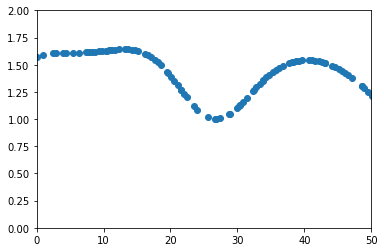

In [65]:
plt.scatter(S, rate / (1.0 + np.exp(-val)))
plt.ylim((0,rate))
plt.xlim((0,measure))
plt.show()

In [ ]:
X_pred = np.random.uniform(low=0.0, high=measure,size=(50,1))
mu, sigma = conditional(X_pred, S, val, kern)
Y_pred = np.random.multivariate_normal(mu, sigma)
plt.scatter(X_pred, rate / (1 + np.exp(-Y_pred)))
plt.ylim((0,rate))
plt.show()

In [ ]:
print(hyper_params)
kern = GPy.kern.RBF(input_dim=1, lengthscale=hyper_params[0], variance=hyper_params[1])
plt.scatter(S, rate / (1 + np.exp(-np.random.multivariate_normal(np.zeros((S.shape[0])), kern.K(S, S)))))
plt.show()

In [ ]:
print(S.shape, Z.shape)
                     
plt.xlim((0,5))
plt.scatter(S_k, Z_k)
plt.show()
plt.ylim((0,10))
plt.xlim((0,5))
plt.scatter(S, rate / (1 + np.exp(-val)))
plt.show()

# End of Relevant Code


# Junk Code below this cell. Please do not read.

In [ ]:
S = np.concatenate((x_K,x_M), axis=0)
print(x_K.shape, val.shape)
plt.scatter(x_K, rate / (1 + np.exp(-val[:K])))
plt.show()
print(k.K(S, S))
print(C)
print(rate, measure)

In [ ]:
print(len(x_K), len(x_M))

In [ ]:

K = len(x_K)
M = len(x_M)
print(N)
print(K,M)
plt.scatter(S, G)
plt.show()

In [ ]:
X = tf.constant(C)
F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)

prior_loss = 0.5*tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
prior_loss = tf.squeeze(prior_loss)

In [ ]:
#tf.ones(shape=[K])
#tf.slice(F, [0], [K])
likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
loss = prior_loss + likelihood_loss
train_op = tf.train.AdadeltaOptimizer(0.01, 0.95, 1e-5).minimize(loss)
#train_op = tf.train.GradientDescentOptimizer(1e-7).minimize(loss)
init_OP = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init_OP)
    l = sess.run(loss)
    print(l)
    for i in range(100):
        #print(sess.run(tf.gradients(loss, F)))
        sess.run(train_op)
        l = sess.run(loss)
        print(l)
        
    val = sess.run(F)
    
import tqdm

In [ ]:
plt.scatter(S, val)
plt.show()

In [ ]:
#     kern = GPy.kern.RBF(input_dim=1, lengthscale=hyper_params[0], variance=hyper_params[1])
#     D = S.shape[1]       # Dimension of the space
#     M = len(x_M)
#     C = k.K(S,S).astype(np.float32)
#     #chol = np.linalg.cholesky(np.linalg.inv(C + 1e-6 * np.eye(N)))
#     #G = np.matmul(chol, G)
#     ## Learn function values via gradient optimization
#     X = tf.constant(C)
#     F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)
#     prior_loss = 0.5 * tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
#     #prior_loss = 0.5 * tf.matmul(tf.expand_dims(F, axis=0), tf.expand_dims(F, axis=1))
#     prior_loss = tf.squeeze(prior_loss)
#     likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
#     likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
#     loss = prior_loss + likelihood_loss
#     train_op = tf.train.AdadeltaOptimizer(0.01,0.95,1e-5).minimize(loss)
#     init_OP = tf.global_variables_initializer()
#     max_it = 500
#     with tf.Session() as sess:
#         sess.run(init_OP)
#         for i in range(max_it):
#             err, _ = sess.run([loss, train_op])
#         val = sess.run(F)
#     print(err)